[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Denis-R-V/TSR/blob/main/sign_detector.ipynb)

# Система распознавания дорожных знаков на датасете RTSD

In [1]:
colab = False

if colab == True:
    from google.colab import drive
    drive.mount('/content/drive')
    !pip install kaggle
    !mkdir ~/.kaggle
    !cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json
    !kaggle datasets download watchman/rtsd-dataset
    !unzip rtsd-dataset.zip
    !rm rtsd-dataset.zip
    !cp -r rtsd-frames/rtsd-frames/ .
    !rm -r rtsd-frames/rtsd-frames/
    !pip install fiftyone
if colab == True:
    dataset_path = '.'
else:
    dataset_path = 'data'
    checkpoints_path = '../checkpoints'

In [2]:
import os
import json
import numpy as np 
import pandas as pd 

from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from pycocotools.coco import COCO
import fiftyone as fo
import time
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
import cv2

## Обучение модели

In [3]:
import os
import json
#import numpy as np 
import pandas as pd 

from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from pycocotools.coco import COCO
import fiftyone as fo
import time
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
#import torchvision.transforms as transforms
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
import cv2
#PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0

In [4]:
#from PIL import Image
#img = Image.open('data/rtsd-frames/autosave01_02_2012_09_16_49.jpg').convert("RGB")
#img

### Загрузчик данных

In [4]:
# Преобразование классов знаков в 1 класс
def anno_to_bin_class(anno_file):
    '''Функция создает копию файла с аннотацией, преобразует все классы в 1 (знак)
    и сохраняет новый файл с аннотацией'''
    with open(os.path.join(dataset_path, anno_file), 'r') as read_file:
        anno_json = json.load(read_file)
    read_file.close()

    for i in range(len(anno_json['annotations'])):
        anno_json['annotations'][i]['category_id'] = 1    
    
    anno_json['categories'] = [{'id': 1, 'name': 'sign'}]
    
    anno_file_new = anno_file.split('.')[0] + '_bin_class.json'
    
    with open(os.path.join(dataset_path, anno_file_new), 'w') as f:
        json.dump(anno_json, f)#ensure_ascii=False, indent=4)
    f.close()

    return anno_json
anno_to_bin_class('train_anno.json')
anno_to_bin_class('train_anno_reduced.json')
anno_to_bin_class('val_anno.json')


{'images': [{'id': 22978,
   'width': 1280,
   'height': 720,
   'file_name': 'rtsd-frames/autosave10_10_2012_13_50_36_1.jpg'},
  {'id': 53820,
   'width': 1280,
   'height': 720,
   'file_name': 'rtsd-frames/autosave24_10_2012_10_20_51_2.jpg'},
  {'id': 52206,
   'width': 1280,
   'height': 720,
   'file_name': 'rtsd-frames/autosave23_10_2012_14_41_26_0.jpg'},
  {'id': 48186,
   'width': 1280,
   'height': 720,
   'file_name': 'rtsd-frames/autosave23_10_2012_10_16_35_2.jpg'},
  {'id': 41953,
   'width': 1280,
   'height': 720,
   'file_name': 'rtsd-frames/autosave16_10_2012_11_44_25_2.jpg'},
  {'id': 38421,
   'width': 1280,
   'height': 720,
   'file_name': 'rtsd-frames/autosave16_10_2012_08_45_17_4.jpg'},
  {'id': 27187,
   'width': 1920,
   'height': 1080,
   'file_name': 'rtsd-frames/autosave13_04_2013_13_38_32_1.jpg'},
  {'id': 19104,
   'width': 1280,
   'height': 720,
   'file_name': 'rtsd-frames/autosave10_10_2012_10_00_59_0.jpg'},
  {'id': 58486,
   'width': 1280,
   'height'

In [5]:
with open(os.path.join(dataset_path, 'train_anno_bin_class.json'), 'r') as read_file:
    temp = json.load(read_file)
read_file.close()
len(temp.get('images'))

54188

In [75]:
train_anno_coco = COCO(os.path.join(dataset_path, 'train_anno_bin_class.json'))

loading annotations into memory...
Done (t=0.37s)
creating index...
index created!


In [8]:
# получение идентификатора категории
train_anno_coco.getCatIds(['sign'])

[1]

In [9]:
# получение ID аннотации для указанного ID изображения
annotation_ids = train_anno_coco.getAnnIds(imgIds=95)
annotation_ids

[175, 176, 177]

In [10]:
# получение ID изображений, содержащих объект с указанным ID
len(train_anno_coco.getImgIds(catIds=[1]))

54188

In [11]:
# получение ID аннотации для указанных ID изображения и ID категории
annotation_ids = train_anno_coco.getAnnIds(imgIds=95, catIds=[1])
annotation_ids

[175, 176, 177]

In [12]:
def pycocotools_visualizer(image_id, category_id = None):
    '''функция по выводу изображения с указанным ID
    и визуализацией аннотаций с выбранными ID категорий (список)
    Если ID категорий не указаны - выводятся все аннотации для изображения'''
    if category_id:
        annotation_ids = train_anno_coco.getAnnIds(imgIds=image_id, catIds=category_id)
    else:
        annotation_ids = train_anno_coco.getAnnIds(imgIds=image_id)
            
    # загрузка аннотаций в список
    anns = train_anno_coco.loadAnns(annotation_ids)

    # путь к изображению и его название
    images_path = dataset_path
    image_name = train_anno_coco.imgs.get(image_id).get('file_name')
    image = Image.open(os.path.join(images_path, image_name))
    
    fig, ax = plt.subplots()
    fig.set_size_inches(18, 10)
    
    # Draw boxes and add label to each box
    for ann in anns:
        box = ann['bbox']
        bb = patches.Rectangle((box[0],box[1]), box[2],box[3], linewidth=1, edgecolor="yellow", facecolor="none")
        ax.add_patch(bb)
    
    ax.imshow(image)
    plt.show()

In [13]:
pycocotools_visualizer(95, [1])

C:\Users\User\AppData\Local\Temp\ipykernel_10792\4181196525.py:28: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


In [14]:
# загрузка датасета

# The directiry containing the source images
data_path = dataset_path      # можно не указывать, если в JSON путь совпадает

# The path yo the COCO labels JSON file
labels_file = "train_anno_bin_class.json"
labels_path = os.path.join(dataset_path, labels_file)


# Import the dataset
dataset = fo.Dataset.from_dir(
    dataset_type=fo.types.COCODetectionDataset,
    data_path=data_path,
    labels_path=labels_path
)

 100% |█████████████| 54188/54188 [1.4m elapsed, 0s remaining, 687.1 samples/s]      


In [15]:
# Визуализация набора данных
session = fo.launch_app(dataset)

In [16]:
# Использование агрегатов с помощью API для получения статистики о наборе данных
# Количество обнаружений для каждой категории
dataset.count_values("detections.detections.label")

{'sign': 95492}

In [1]:
colab = False

if colab == True:
    from google.colab import drive
    drive.mount('/content/drive')
    !pip install kaggle
    !mkdir ~/.kaggle
    !cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json
    !kaggle datasets download watchman/rtsd-dataset
    !unzip rtsd-dataset.zip
    !rm rtsd-dataset.zip
    !cp -r rtsd-frames/rtsd-frames/ .
    !rm -r rtsd-frames/rtsd-frames/
    !pip install fiftyone
if colab == True:
    dataset_path = '.'
else:
    dataset_path = 'data'

In [2]:
import os
import json
import numpy as np 
import pandas as pd 

from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

from pycocotools.coco import COCO
import fiftyone as fo
import time
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
#import torchvision.transforms as transforms
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
import cv2
#PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0

In [194]:
class RTSD_dataset(Dataset):
  
    def __init__(self, json_path, img_path, transforms):
        self.json_path = json_path
        self.img_path = img_path
        self.tranfforms = transforms

        with open(json_path, 'r') as read_file:
            self.anno = json.load(read_file)
        read_file.close()

        self.df_dataset = pd.DataFrame(self.anno.get('annotations'))
        self.test = self.df_dataset.copy()
        #self.test['bbox_for_rcnn'] = self.test.bbox[0]
        self.df_images = pd.DataFrame(self.anno.get('images'))
        self.df_images.rename(columns={'id':'image_id'}, inplace=True)
        self.df_dataset = self.df_dataset.merge(self.df_images)
        self.df_dataset = self.df_dataset[['file_name', 'bbox', 'category_id']].groupby('file_name', as_index=False).agg(list)

    def get_df(self):
        #return self.df_dataset
        return self.test

    def __len__(self):
        return self.df_dataset.shape[0]
  
    def __getitem__(self, index):
        img_name = self.df_dataset.loc[index,'file_name']
        img = cv2.imread(os.path.join(self.img_path, img_name))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
        #img = torch.from_numpy(img).permute(2, 0, 1).to(torch.float)
        img = img/255.
        #img = Image.open(os.path.join(self.img_path, img_name))
        #img = np.array(img)
        
        boxes = []
        for box in self.df_dataset.loc[index,'bbox']:
            box_for_rcnn = [box[0], box[1], box[0] + box[2], box[1] + box[3]]
            boxes.append(box_for_rcnn)
        boxes = torch.Tensor(boxes).to(torch.float)            # возможно нужно преобразовать x_max и y_max
        #boxes = torch.Tensor(self.df_dataset.loc[index, 'bbox']).to(torch.float)
        labels = torch.Tensor(self.df_dataset.loc[index, 'category_id']).to(torch.int64)
        #area = (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 0])
        #iscrowd = torch.zeros(labels.shape[0], dtype=torch.int64)
        
        #transform = self.tranfforms
        #transformed = transform(image=img, bboxes=boxes, labels=labels)
        transformed = self.tranfforms(image=img, bboxes=boxes, labels=labels)
        img = transformed['image']
        boxes = torch.Tensor(transformed['bboxes'])
        #for i in range(10):
        try:
            boxes.shape[1]
        except IndexError:
            img_name = self.df_dataset.loc[index,'file_name']
            img = cv2.imread(os.path.join(self.img_path, img_name))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
            img = img/255.
            boxes = []
            for box in self.df_dataset.loc[index,'bbox']:
                box_for_rcnn = [box[0], box[1], box[0] + box[2], box[1] + box[3]]
                boxes.append(box_for_rcnn)
            boxes = torch.Tensor(boxes).to(torch.float)            # возможно нужно преобразовать x_max и y_max
            labels = torch.Tensor(self.df_dataset.loc[index, 'category_id']).to(torch.int64)
            transformed = self.tranfforms(image=img, bboxes=boxes, labels=labels)
            img = transformed['image']
            boxes = torch.Tensor(transformed['bboxes'])
            
        #if self.transforms is not None:    
        #    img, target = self.transforms(img, target)

        #img = img/255.
        target = {}
        target['boxes'] = boxes
        target['labels'] = torch.Tensor(self.df_dataset.loc[index, 'category_id']).to(torch.int64)
        return img, target

In [238]:
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
    # Send train=True fro training transforms and False for val/test transforms
def get_transform(train=False):
    if train==True:
        return A.Compose([A.HorizontalFlip(p=0.5),
                          A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.8),
                          A.RandomFog(fog_coef_lower=0.2, fog_coef_upper=0.3, alpha_coef=0.1, p=0.05), #Туман
                          A.RandomRain(brightness_coefficient=0.9, drop_width=1, blur_value=5, p=0.05),
                          A.Rotate(limit=10, p=0.5),
                          #A.RandomShadow(num_shadows_lower=1, num_shadows_upper=1, shadow_dimension=5, shadow_roi=(0, 0.5, 1, 1), p=1),
                          #A.RandomSnow(brightness_coeff=1.5, snow_point_lower=0.3, snow_point_upper=0.5, p=1),
                          #A.RandomSunFlare(flare_roi=(0, 0, 1, 0.5), angle_lower=0.5, p=1),
                          # ToTensorV2 converts image to pytorch tensor without div by 255
                          ToTensorV2(p=1.0)
                          ],
                          bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))
        
    else:
        return A.Compose([
                            ToTensorV2(p=1.0)
                        ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))

In [29]:
'''import torchvision.transforms as T

def get_transform(train):
    transforms = []
    transforms.append(T.PILToTensor())
    transforms.append(T.ConvertImageDtype(torch.float))
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)'''

In [239]:
test = RTSD_dataset(json_path = 'data/train_anno_reduced_bin_class.json',
                    img_path = 'data/',
                    transforms = get_transform(train=True)
                    )

In [152]:
img, target = test.__getitem__(24)
target

{'boxes': tensor([[743.7462, 307.7349, 785.5602, 351.4017],
         [743.7462, 307.7349, 785.5602, 351.4017]]),
 'labels': tensor([1, 1])}

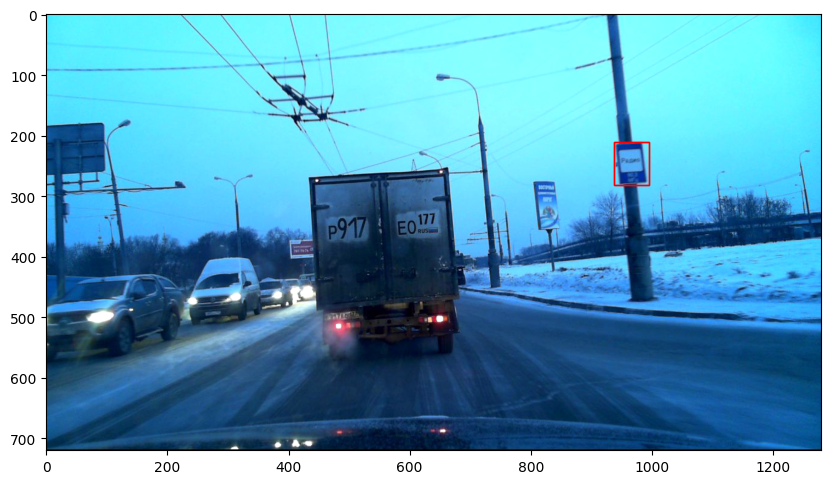

In [376]:
def plot_img_bbox(img, target):
    # plot the image and bboxes
    # Bounding boxes are defined as follows: x-min y-min width height
    fig, a = plt.subplots(1,1)
    fig.set_size_inches(10,10)
    a.imshow(img)
    for box in (target['boxes']):
        x, y, width, height  = box[0], box[1], box[2]-box[0], box[3]-box[1]
        rect = patches.Rectangle((x, y),
                                 width, height,
                                 linewidth = 1,
                                 edgecolor = 'r',
                                 facecolor = 'none')

        # Draw the bounding box on top of the image
        a.add_patch(rect)
    plt.show()
    
# plotting the image with bboxes. Feel free to change the index
#img, target = my_dataset[25]
img, target = test.__getitem__(1)
img = img.permute(1, 2, 0).detach().numpy()
img = img*255
img = img.astype(np.uint8)
plot_img_bbox(img, target)

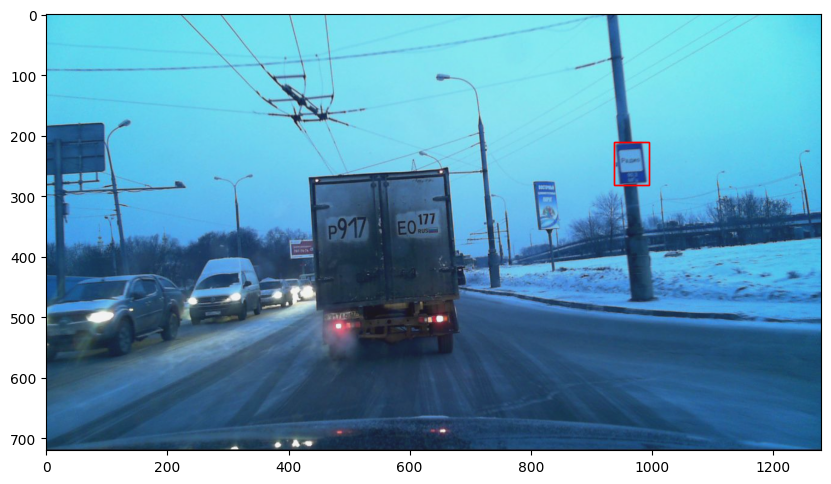

In [248]:
plot_img_bbox(img, target)

In [8]:
del test

### Формирование батча

In [21]:
def collate_fn(batch):
    return tuple(zip(*batch))

### Гиперпараметры

In [22]:
device_id = 0
if torch.cuda.is_available() == True:
    device = f'cuda:{device_id}'
elif torch.backends.mps.is_available() == True:
    device = 'mps'
else:
    device = 'cpu'
n_epochs = 10
batch_size = 8
num_classes = 2

In [11]:
device

'cuda:0'

### Инициализация модели, задание оптимизатора и функции потерь

In [23]:
def create_model(num_classes, pretrained=True):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights='FasterRCNN_ResNet50_FPN_Weights.COCO_V1')
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

In [24]:
model = create_model(num_classes=2, pretrained=True).to(device)




# parameters
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

#params = [p for p in model.parameters() if p.requires_grad]

#optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9, weight_decay=0.0005)
#optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=0.0005)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)



#optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
    # and a learning rate scheduler
#lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)
train_dataset = RTSD_dataset(os.path.join(dataset_path, 'train_anno_bin_class.json'),
                                          dataset_path,
                                          transforms = get_transform(train=True)
                                          )
val_dataset = RTSD_dataset(os.path.join(dataset_path, 'val_anno_bin_class.json'),
                                        dataset_path,
                                          transforms = get_transform(train=False)
                                          )

train_data_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    #num_workers=4,
    collate_fn=collate_fn
)

val_data_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    #num_workers=4,
    collate_fn=collate_fn
)

In [14]:
len_ds_train = train_dataset.__len__()
n=37000
for i in range(37000, len_ds_train):
    if  train_dataset.__getitem__(i)[1]['boxes'].shape[1] != 4:
        n+=1
        print(i)
    if i%1000 == 0:
        print(f"Пройдено {i}/{len_ds_train}")

Пройдено 37000/54188


KeyboardInterrupt: 

In [32]:
len_ds_train = train_dataset.__len__()
n=0
for i in range(len_ds_train):
    if  train_dataset.__getitem__(i)[1]['boxes'].shape[1] != 4:
        n+=1
        print(i)
    if i%1000 == 0:
        print(f"Пройдено {i}/{len_ds_train}")

Пройдено 0/54188
Пройдено 1000/54188
Пройдено 2000/54188
Пройдено 3000/54188
Пройдено 4000/54188
Пройдено 5000/54188
Пройдено 6000/54188
Пройдено 7000/54188
Пройдено 8000/54188
Пройдено 9000/54188
Пройдено 10000/54188
Пройдено 11000/54188
Пройдено 12000/54188
Пройдено 13000/54188
Пройдено 14000/54188
Пройдено 15000/54188
Пройдено 16000/54188
Пройдено 17000/54188
Пройдено 18000/54188
Пройдено 19000/54188
Пройдено 20000/54188
Пройдено 21000/54188
Пройдено 22000/54188
Пройдено 23000/54188
Пройдено 24000/54188
Пройдено 25000/54188
Пройдено 26000/54188
Пройдено 27000/54188
Пройдено 28000/54188
Пройдено 29000/54188
Пройдено 30000/54188
Пройдено 31000/54188
Пройдено 32000/54188
Пройдено 33000/54188
Пройдено 34000/54188
Пройдено 35000/54188
Пройдено 36000/54188
Пройдено 37000/54188


IndexError: tuple index out of range

In [33]:
n

0

In [31]:
train_dataset.__getitem__(i)[1]['boxes'].shape

91

### Трейн луп

In [25]:
def train(train_dataloader, epoch): 
    len_dataloader = len(train_dataloader)
    model.train()
    running_loss = 0
    for i, data in enumerate(train_dataloader):
        optimizer.zero_grad()
        images, targets = data[0], data[1]
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        loss_dict = model(images, targets)
        loss = sum(loss for loss in loss_dict.values())
        running_loss += loss.item()
        loss.backward()
        optimizer.step()
        if i % 50 == 0:
            print(f"\tЭпоха {epoch}. Итерация {i}/{len_dataloader}. Loss: {loss}")
    train_loss = running_loss/len(train_dataloader.dataset)
    return train_loss

def val(val_dataloader, epoch):
    running_loss = 0
    for data in val_dataloader:
        optimizer.zero_grad()
        images, targets = data[0], data[1]
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        with torch.no_grad():
            loss_dict = model(images, targets)
        loss_dict = model(images, targets)
        loss = sum(loss for loss in loss_dict.values())
        running_loss += loss.item()
    val_loss = running_loss/len(val_dataloader.dataset)
    return val_loss 

In [379]:
checkpoints_path = 'checkpoints'
test_name = 'test.json'
test_file = {1: 'test'}

with open(os.path.join(checkpoints_path, test_name), 'w') as f:
    json.dump(test_file, f)#ensure_ascii=False, indent=4)
f.close()

In [134]:
#train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)

In [26]:
train_losses = []
val_losses = []
try:
    for epoch in range(n_epochs):
        start = time.time()
        train_loss = train(train_data_loader, epoch)
        val_loss = val(val_data_loader, epoch)
        #lr_scheduler.step()
        print(f"Эпоха #{epoch} train_loss: {train_loss}, val_loss: {val_loss}")  
        end = time.time()
        print(f"Потрачено {round((end - start) / 60, 1)} минут на {epoch} эпоху")
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'lr_scheduler_state_dict': lr_scheduler.state_dict(),
            'losses_train': train_losses,
            'losses_val': val_losses
            }, os.path.join(dataset_path, f'../checkpoints/model_detector_resnet50_augmented_{epoch}.pth'))
    
        torch.save(model, os.path.join(dataset_path, f'../checkpoints/model_detector_resnet50_augmented_full_{epoch}.pth'))
    
except KeyboardInterrupt:
    print('Прервано пользователем')

	Эпоха 0. Итерация 0/6774. Loss: 1.6903111934661865
	Эпоха 0. Итерация 50/6774. Loss: 0.1617080420255661
	Эпоха 0. Итерация 100/6774. Loss: 0.2340809851884842
	Эпоха 0. Итерация 150/6774. Loss: 0.19027931988239288
	Эпоха 0. Итерация 200/6774. Loss: 0.11255015432834625
	Эпоха 0. Итерация 250/6774. Loss: 0.08810511231422424
	Эпоха 0. Итерация 300/6774. Loss: 0.11533234268426895
	Эпоха 0. Итерация 350/6774. Loss: 0.12123119086027145
	Эпоха 0. Итерация 400/6774. Loss: 0.1433386355638504
	Эпоха 0. Итерация 450/6774. Loss: 0.08557531237602234
	Эпоха 0. Итерация 500/6774. Loss: 0.1737474948167801
	Эпоха 0. Итерация 550/6774. Loss: 0.12387401610612869
	Эпоха 0. Итерация 600/6774. Loss: 0.14221610128879547
	Эпоха 0. Итерация 650/6774. Loss: 0.0875408798456192
	Эпоха 0. Итерация 700/6774. Loss: 0.08311673253774643
	Эпоха 0. Итерация 750/6774. Loss: 0.14547374844551086
	Эпоха 0. Итерация 800/6774. Loss: 0.17877300083637238
	Эпоха 0. Итерация 850/6774. Loss: 0.12732084095478058
	Эпоха 0. Итерация 

In [29]:
train_losses, val_losses

([0.014400107387186303], [0.010745501028001309])

In [51]:
'''torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'lr_scheduler_state_dict': lr_scheduler.state_dict(),
    'losses_train': train_losses,
    'losses_val': val_losses
    }, os.path.join(dataset_path, f'../checkpoints/model_detector_resnet50_augmented_{epoch}.pth'))'''

In [12]:
def create_model(num_classes, pretrained=True):
    model =torchvision.models.detection.fasterrcnn_mobilenet_v3_large_fpn(weights='FasterRCNN_MobileNet_V3_Large_FPN_Weights.DEFAULT')
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

In [13]:
model = create_model(num_classes=2, pretrained=True).to(device)




# parameters
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

#params = [p for p in model.parameters() if p.requires_grad]

#optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9, weight_decay=0.0005)
#optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=0.0005)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)



#optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
    # and a learning rate scheduler
#lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)
train_dataset = RTSD_dataset(os.path.join(dataset_path, 'train_anno_bin_class.json'),
                                          dataset_path)
val_dataset = RTSD_dataset(os.path.join(dataset_path, 'val_anno_bin_class.json'), dataset_path)

train_data_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    #num_workers=4,
    collate_fn=collate_fn
)

val_data_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    #num_workers=4,
    collate_fn=collate_fn
)

Downloading: "https://download.pytorch.org/models/fasterrcnn_mobilenet_v3_large_fpn-fb6a3cc7.pth" to C:\Users\User/.cache\torch\hub\checkpoints\fasterrcnn_mobilenet_v3_large_fpn-fb6a3cc7.pth


  0%|          | 0.00/74.2M [00:00<?, ?B/s]

In [14]:
def train(train_dataloader, epoch): 
    len_dataloader = len(train_dataloader)
    model.train()
    running_loss = 0
    for i, data in enumerate(train_dataloader):
        optimizer.zero_grad()
        images, targets = data[0], data[1]
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        loss_dict = model(images, targets)
        loss = sum(loss for loss in loss_dict.values())
        running_loss += loss.item()
        loss.backward()
        optimizer.step()
        if i % 50 == 0:
            print(f"\tЭпоха {epoch}. Итерация {i}/{len_dataloader}. Loss: {loss}")
    train_loss = running_loss/len(train_dataloader.dataset)
    return train_loss

def val(val_dataloader, epoch):
    running_loss = 0
    for data in val_dataloader:
        optimizer.zero_grad()
        images, targets = data[0], data[1]
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        with torch.no_grad():
            loss_dict = model(images, targets)
        loss_dict = model(images, targets)
        loss = sum(loss for loss in loss_dict.values())
        running_loss += loss.item()
    val_loss = running_loss/len(val_dataloader.dataset)
    return val_loss 

In [15]:
train_losses = []
val_losses = []
try:
    for epoch in range(n_epochs):
        start = time.time()
        train_loss = train(train_data_loader, epoch)
        val_loss = val(val_data_loader, epoch)
        #lr_scheduler.step()
        print(f"Эпоха #{epoch} train_loss: {train_loss}, val_loss: {val_loss}")  
        end = time.time()
        print(f"Потрачено {round((end - start) / 60, 1)} минут на {epoch} эпоху")
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'lr_scheduler_state_dict': lr_scheduler.state_dict(),
            'losses_train': train_losses,
            'losses_val': val_losses
            }, os.path.join(dataset_path, f'../checkpoints/model_detector_resnet50_augmented_{epoch}.pth'))
    torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'lr_scheduler_state_dict': lr_scheduler.state_dict(),
    'losses_train': train_losses,
    'losses_val': val_losses
    }, os.path.join(dataset_path, f'../checkpoints/model_detector_resnet50_augmented_full.pth'))
except KeyboardInterrupt:
    print('Прервано пользователем')

	Эпоха 0. Итерация 0/6774. Loss: 0.8358988165855408
	Эпоха 0. Итерация 50/6774. Loss: 0.09858530014753342
	Эпоха 0. Итерация 100/6774. Loss: 0.2172754555940628
	Эпоха 0. Итерация 150/6774. Loss: 0.40015822649002075
	Эпоха 0. Итерация 200/6774. Loss: 0.13395972549915314
	Эпоха 0. Итерация 250/6774. Loss: 0.28839361667633057
	Эпоха 0. Итерация 300/6774. Loss: 0.2116183489561081
	Эпоха 0. Итерация 350/6774. Loss: 0.2833598256111145
	Эпоха 0. Итерация 400/6774. Loss: 0.2793215811252594
	Эпоха 0. Итерация 450/6774. Loss: 0.309714674949646
	Эпоха 0. Итерация 500/6774. Loss: 0.20718857645988464
	Эпоха 0. Итерация 550/6774. Loss: 0.26163995265960693
	Эпоха 0. Итерация 600/6774. Loss: 0.35022008419036865
	Эпоха 0. Итерация 650/6774. Loss: 0.25102320313453674
	Эпоха 0. Итерация 700/6774. Loss: 0.36677470803260803
	Эпоха 0. Итерация 750/6774. Loss: 0.34893864393234253
	Эпоха 0. Итерация 800/6774. Loss: 0.32514622807502747
	Эпоха 0. Итерация 850/6774. Loss: 0.2878253161907196
	Эпоха 0. Итерация 90

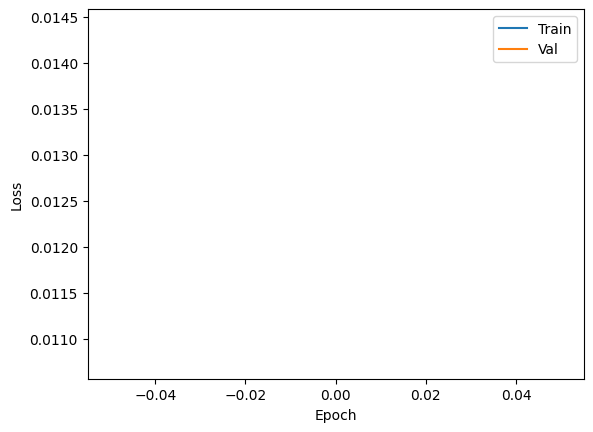

In [27]:
%matplotlib inline
fig, ax = plt.subplots()
ax.plot(train_losses, label='Train')
ax.plot(val_losses, label='Val')
#ax.plot(val_losses, label='Val')
ax.set(xlabel='Epoch', ylabel='Loss')
ax.legend()
plt.show()